# MOM-CV
Adaptive choice of number of blocks and regularization parameter for the MOM estimator (via ADMM).

In [1]:
import nbimporter
import MOM_LASSO as MOM_LASSO 

import numpy as np
from numpy.random import multivariate_normal, randn
from numpy.linalg import norm
from numpy import sqrt
from scipy.linalg import svd
from scipy.linalg.special_matrices import toeplitz
from scipy import linalg
import matplotlib.pylab as plt
import time
from sklearn.utils import shuffle

np.set_printoptions(precision=2)
%matplotlib inline
%load_ext autoreload

Importing Jupyter notebook from MOM_LASSO.ipynb


SyntaxError: invalid syntax (<ipython-input-2-e49d01f4a9e4>, line 1)

In [2]:
N, n_features, sparsity, sigma = 100, 30, 10, 0
np.random.seed(50)

beta_0 = MOM_LASSO.beta_func(n_features, sparsity)
y, X = MOM_LASSO.data1(N, beta_0, sigma)

beta_0 = np.matrix(beta_0).T
y = np.matrix(y).T
X = np.matrix(X)

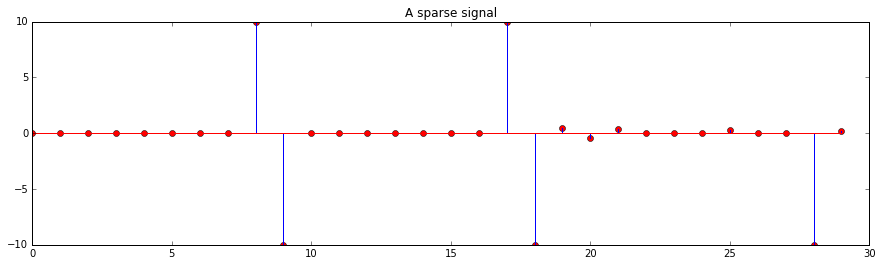

In [3]:
plt.figure(figsize = (15, 4))
plt.stem(beta_0, markerfmt='ro', label='true')
plt.title('A sparse signal')

## Construction of training / test sets

In [4]:
def cv_data(X, y, V, ind_split = 1):
    N = y.size
    ind = np.arange(ind_split*int(N/V), (ind_split+1)*int(N/V))
    return np.delete(X, ind, axis = 0), np.delete(y, ind, axis = 0), X[ind], y[ind]

In [5]:
X_train, y_train, X_test, y_test = cv_data(X, y, 5, 4)

## Construction of the MOM-cv matrix criterium (xaxis $K$ and yaxis $\lambda$)

In [6]:
def block_cv(X_test, y_test, x, K_prime):
    vect_means = []
    N = y_test.size
    for k in np.arange(0, K_prime):
        Xk, yk = X_test[k*int(N/K_prime):(k+1)*int(N/K_prime)], y_test[k*int(N/K_prime):(k +1)*int(N/K_prime)]
        excess_loss_k = linalg.norm(Xk.dot(x) - yk) ** 2
        vect_means.append(excess_loss_k)
    idx_med = MOM_LASSO.median_index(vect_means)
    #print(idx_med)
    return X_test[idx_med*int(N/K_prime):(idx_med+1)*int(N/K_prime)], y_test[idx_med*int(N/K_prime):(idx_med+1)]

In [7]:
def mom_cv_admm(X, y, beta_0, max_iter, V, K_prime, grid_K, grid_lamda = [1]):
    N = y.size
    cv_error_lamda_K = np.zeros((grid_lamda.size, grid_K.size))
    ind_lamda = 0
    for lamda in grid_lamda:
        ind_K = 0
        for K in grid_K:
            print('----------lamda = {} --------K = {}'.format(lamda, K))
            cv_error = []
            for ind_split in np.arange(0, V):
                X_train, y_train, X_test, y_test = cv_data(X, y, V, ind_split)
                _, _, mom_x_admm = MOM_LASSO.MOM_ADMM(X_train, y_train, beta_0, K, max_iter, lamda)
                Xk_test, yk_test = block_cv(X_test, y_test, mom_x_admm, K_prime)
                r = Xk_test*mom_x_admm - yk_test
                #print('------r = {}'.format(r))
                cv_error.append(np.linalg.norm(r))
            cv_error_lamda_K[ind_lamda, ind_K] = np.median(cv_error)
            print('-----cv_error_lamda_K = {}'.format(np.median(cv_error)))
            ind_K = ind_K + 1
        ind_lamda = ind_lamda + 1
    return cv_error_lamda_K

In [8]:
grid_lamda = np.arange(0, 10, 1)/sqrt(N)
grid_K = np.arange(1, int(N/5), 5)
max_iter, V, K_prime = 100, 5, 3
perf = mom_cv_admm(X, y, beta_0, max_iter, V, K_prime, grid_K, grid_lamda)

----------lamda = 0.0 --------K = 1
-----cv_error_lamda_K = 3.118126145114878e-14
----------lamda = 0.0 --------K = 6
-----cv_error_lamda_K = 1.3801724327825164
----------lamda = 0.0 --------K = 11
-----cv_error_lamda_K = 25.873638634514496
----------lamda = 0.0 --------K = 16
-----cv_error_lamda_K = 27.413276921878047
----------lamda = 0.1 --------K = 1
-----cv_error_lamda_K = 0.015324535904190773
----------lamda = 0.1 --------K = 6
-----cv_error_lamda_K = 0.5789781733150562
----------lamda = 0.1 --------K = 11
-----cv_error_lamda_K = 9.430037242396274
----------lamda = 0.1 --------K = 16
-----cv_error_lamda_K = 21.949699891268477
----------lamda = 0.2 --------K = 1
-----cv_error_lamda_K = 0.030649993401835628
----------lamda = 0.2 --------K = 6
-----cv_error_lamda_K = 1.136905377222595
----------lamda = 0.2 --------K = 11
-----cv_error_lamda_K = 15.837219125764518
----------lamda = 0.2 --------K = 16
-----cv_error_lamda_K = 12.167942927948385
----------lamda = 0.3 --------K = 1
-----

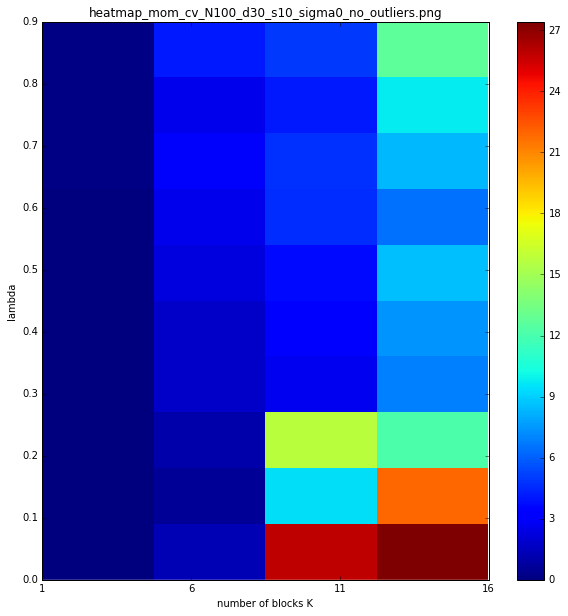

In [9]:
plt.figure(figsize = (10, 10))
K_min, K_max, lamda_min, lamda_max = np.min(grid_K), np.max(grid_K), np.min(grid_lamda), np.max(grid_lamda)
fig = plt.imshow(perf, interpolation="none", aspect='auto', origin = 'lower', extent=[K_min, K_max, lamda_min, lamda_max])
plt.colorbar()
plt.axis('on')
plt.xticks(grid_K)
plt.yticks(grid_lamda)
#titre = "Gaussian measurements"
#plt.title(titre)
plt.ylabel('lambda')
plt.xlabel('number of blocks K')
titre = 'heatmap_mom_cv_N{}_d{}_s{}_sigma{}_no_outliers.png'.format(N, n_features, sparsity, sigma)
plt.title(titre)
#plt.savefig(titre)

## Choice of $K$ and $\lambda$

In [8]:
def ind_K_lamda(cv_error_lamda_K, grid_K, grid_lamda):
    ind = np.unravel_index(cv_error_lamda_K.argmin(), cv_error_lamda_K.shape)
    print('---- best choice: lambda={} and K={}'.format(grid_lamda[ind[0]], grid_K[ind[1]]))
    return grid_lamda[ind[0]], grid_K[ind[1]]

In [9]:
lamda, K = ind_K_lamda(perf, grid_K, grid_lamda)

NameError: name 'perf' is not defined

## A case with outliers

In [10]:
n_features, sparsity = 200, 10
n_samples, n_outliers, n_heavy_tail = 100, 10, 10
N = n_samples + n_outliers + n_heavy_tail
sigma = 1

beta_0 = MOM_LASSO.beta_func(n_features, sparsity)
y1, X1 = MOM_LASSO.data1(n_samples, beta_0,  sigma)
y2, X2 = MOM_LASSO.data2(n_outliers, n_features, type_outliers = 2, beta = 1, rho=1)
y3, X3 = MOM_LASSO.data3(n_heavy_tail, beta_0, deg = 2)
y, X = MOM_LASSO.data_merge(y1, X1, y2, X2)
y, X = MOM_LASSO.data_merge(y, X, y3, X3)

beta_0 = np.matrix(beta_0).T
y = np.matrix(y).T
X = np.matrix(X)

In [13]:
grid_lamda = np.arange(0, 10, 1)/sqrt(N)
grid_K = np.arange(1, int(N/5), 4)
max_iter, V, K_prime = 100, 5, 3
perf = mom_cv_admm(X, y, beta_0, max_iter, V, K_prime, grid_K, grid_lamda)

----------lamda = 0.0 --------K = 1
-----cv_error_lamda_K = 1599.8807514174496
----------lamda = 0.0 --------K = 5
-----cv_error_lamda_K = 1414.343750333626
----------lamda = 0.0 --------K = 9
-----cv_error_lamda_K = 1932.586471420413
----------lamda = 0.0 --------K = 13
-----cv_error_lamda_K = 2346.142825568842
----------lamda = 0.0 --------K = 17
-----cv_error_lamda_K = 2212.8143258507093
----------lamda = 0.0 --------K = 21
-----cv_error_lamda_K = 2301.5958439323485
----------lamda = 0.09128709291752768 --------K = 1
-----cv_error_lamda_K = 1600.6156613063863
----------lamda = 0.09128709291752768 --------K = 5
-----cv_error_lamda_K = 1413.4358164647667
----------lamda = 0.09128709291752768 --------K = 9
-----cv_error_lamda_K = 1936.5850875261738
----------lamda = 0.09128709291752768 --------K = 13
-----cv_error_lamda_K = 2260.6529554304016
----------lamda = 0.09128709291752768 --------K = 17
-----cv_error_lamda_K = 2213.3526818217897
----------lamda = 0.09128709291752768 --------K =

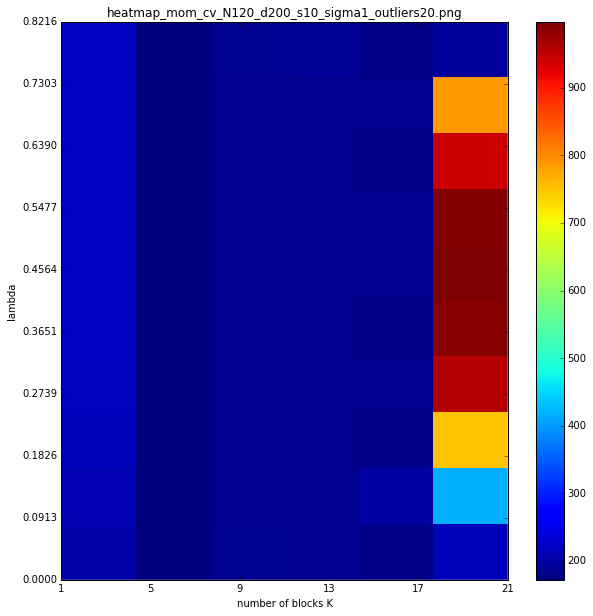

In [90]:
plt.figure(figsize = (10, 10))
K_min, K_max, lamda_min, lamda_max = np.min(grid_K), np.max(grid_K), np.min(grid_lamda), np.max(grid_lamda)
fig = plt.imshow(perf, interpolation="none", aspect='auto', origin = 'lower', extent=[K_min, K_max, lamda_min, lamda_max])
plt.colorbar()
plt.xticks(grid_K)
plt.yticks(grid_lamda)
#titre = "Gaussian measurements"
#plt.title(titre)
plt.ylabel('lambda')
plt.xlabel('number of blocks K')
titre = 'heatmap_mom_cv_N{}_d{}_s{}_sigma{}_outliers{}.png'.format(N, n_features, sparsity, sigma, n_outliers + n_heavy_tail)
plt.title(titre)
plt.savefig(titre)

In [91]:
lamda, K = ind_K_lamda(perf, grid_K, grid_lamda)

---- best choice: lambda=0.8215838362577491 and K=5


## Optimal choice of lamda for the LASSO using V-fold CV
To make fair comparison between the LASSO (obtained via ADMM) and the MOM-LASSO (via MOM-ADMM), we also need to choose the regularization parameter $\lambda$ in the LASSO via a data-dependent criteria. We use here the classical V-fold CV approach.

In [11]:
def cv_admm(X, y, beta_0, max_iter, V, grid_lamda):
    N = y.size
    cv_error_lamda = []
    for lamda in grid_lamda:
        print('--------------------------------lamda = {}'.format(lamda))
        cv_error = []
        for ind_split in np.arange(0, V):
            X_train, y_train, X_test, y_test = cv_data(X, y, V, ind_split)
            _, _, x_admm = MOM_LASSO.ADMM(X_train, y_train, beta_0, max_iter, lamda)
            r = X_test*x_admm - y_test
            #print('------r = {}'.format(r))
            cv_error.append(np.linalg.norm(r))
        cv_error_lamda.append(np.mean(cv_error))
        print('-----cv_error_lamda = {}'.format(np.mean(cv_error_lamda)))
    return np.array(cv_error_lamda)

In [12]:
N, n_features, sparsity, sigma = 100, 30, 10, 1
np.random.seed(50)

beta_0 = MOM_LASSO.beta_func(n_features, sparsity)
y, X = MOM_LASSO.data1(N, beta_0, sigma)

beta_0 = np.matrix(beta_0).T
y = np.matrix(y).T
X = np.matrix(X)

In [48]:
grid_lamda = np.arange(0, 100, 10)/sqrt(N)
max_iter, V, = 100, 5
perf = cv_admm(X, y, beta_0, max_iter, V, grid_lamda)

--------------------------------lamda = 0.0
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 1.117639
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 0.815432
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 0.851309
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 0.763563
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 0.713920
-----cv_error_lamda = 4.530031608202959
--------------------------------lamda = 1.0
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 0.952797
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 0.683447
Lauching ADMM solver...
iter= 0, estimation error ADMM = 22.373847
iter= 50, estimation error ADMM = 0

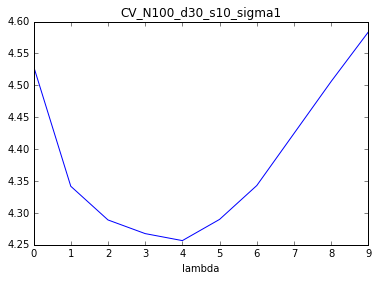

In [55]:
plt.plot(grid_lamda, perf)
titre = 'CV_N{}_d{}_s{}_sigma{}'.format(N, n_features, sparsity, sigma)
plt.title(titre)
plt.xticks(grid_lamda)
plt.xlabel('lambda')
plt.savefig(titre)

In [51]:
def ind_lamda(cv_error_lamda, grid_lamda):
    ind = cv_error_lamda.argmin()
    print('---- best choice: lambda={}'.format(grid_lamda[ind]))
    return grid_lamda[ind]

In [53]:
lamda = ind_lamda(perf, grid_lamda)

---- best choice: lambda=4.0
